# Post-hoc Interpretability of MaxViT

## Introduction
Following the successful training and validation of the MaxViT model for the ordinal classification of androgenetic alopecia, this notebook focuses on the interpretability and transparency phase. In the development of deep learning systems for clinical imaging, achieving optimal quantitative performance metrics (MAE, MSE) is insufficient. It is imperative to validate that the model bases its predictions on coherent biological features rather than dataset biases or background noise.

This document details the implementation of Explainable Artificial Intelligence (XAI) mechanisms to interrogate the "black box" of the model, visualizing the regions of interest (ROI) that activate the multi-axis attention architecture during the inference process.

## Set-up

In [237]:
# %pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch
import kornia.augmentation as K
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

In [238]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load tensors
images_tensor = torch.load('src/data/test/X_test_data.pt', map_location=device)
labels_tensor = torch.load('src/data/test/y_test_data.pt', map_location=device)

# Normalize data with ImageNet statistics
normalize = K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
images_tensor = normalize(images_tensor)
print(images_tensor.shape, labels_tensor.shape)

Using device: cuda
torch.Size([67, 3, 224, 224]) torch.Size([67, 1])


In [239]:
print(labels_tensor[0:10])

tensor([[0.6000],
        [0.8000],
        [0.0000],
        [0.0000],
        [0.2000],
        [1.0000],
        [0.6000],
        [0.0000],
        [1.0000],
        [0.4000]], device='cuda:0')


In [240]:
# Load model
model = torch.load('src/pipeline/model/alopecia_classifier.pt', weights_only=False, map_location=device)
model = model.eval()
summary(model)

Layer (type:depth-idx)                                                                Param #
MaxVit                                                                                --
├─Sequential: 1-1                                                                     --
│    └─Conv2dNormActivation: 2-1                                                      --
│    │    └─Conv2d: 3-1                                                               1,728
│    │    └─BatchNorm2d: 3-2                                                          128
│    │    └─GELU: 3-3                                                                 --
│    └─Conv2dNormActivation: 2-2                                                      --
│    │    └─Conv2d: 3-4                                                               36,928
├─ModuleList: 1-2                                                                     --
│    └─MaxVitBlock: 2-3                                                               --
│    │  

## Gradient-weighted Class Activation Mapping

In [241]:
# Inspect the last MBConv layer
print(model.blocks[-1].layers[-1].layers.MBconv.layers)  # Last convolutional layer

Sequential(
  (pre_norm): BatchNorm2d(512, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (conv_a): Conv2dNormActivation(
    (0): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
  )
  (conv_b): Conv2dNormActivation(
    (0): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2048, bias=False)
    (1): BatchNorm2d(2048, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
  )
  (squeeze_excitation): SqueezeExcitation(
    (avgpool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(128, 2048, kernel_size=(1, 1), stride=(1, 1))
    (activation): SiLU()
    (scale_activation): Sigmoid()
  )
  (conv_c): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
)


In [242]:
# Select the he last convolution as target layer
target_layers = [model.blocks[-1].layers[-1].layers.MBconv.layers.conv_b[0]]

# Create GradCAM object
cam = GradCAM(model=model, target_layers=target_layers)

In [243]:
def visualize_cam_on_image(num_img, images_tensor=images_tensor, labels_tensor=labels_tensor, model=model, cam=cam):

    # Select image
    img = images_tensor[num_img]  # (3, 224, 224)

    # Get model prediction
    with torch.inference_mode():
        prediction = model(img.unsqueeze(0)) # (1, 3, 224, 224) it requires a batch dimension

    # Scale prediction and label
    prediction = prediction.item()
    prediction = prediction * 5

    label = labels_tensor[num_img].cpu().numpy()
    label = (label[0] * 5)

    # Get Grad-CAM  
    grayscale_cam = cam(input_tensor=img.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
    # Get first and only result of the batch
    grayscale_cam_img = grayscale_cam[0, :]


    # Denormalize image with previous ImageNet statistics
    rgb_img = img.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb_img = std * rgb_img + mean
    rgb_img = np.clip(rgb_img, 0, 1)

    # Get heatmap visualization
    visualization = show_cam_on_image(rgb_img, grayscale_cam_img, use_rgb=True)

    # Plot original image and Grad-CAM
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.suptitle(f"MaxVit last layer vision on {label} degree \n  Predicted: {prediction:.3f}", fontsize=14)
    plt.title("Original Image")
    plt.imshow(rgb_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(visualization)
    plt.axis('off')

    plt.show()

### Explicability
In this section 3 samples with different degrees of alopecia will be explain 

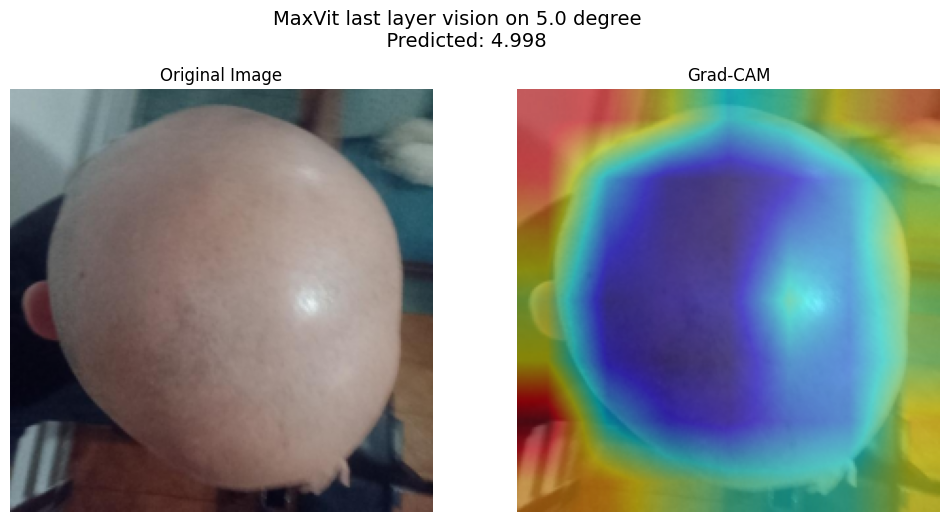

In [244]:
visualize_cam_on_image(5)

**Findings**  
As the cold area sujests the model is ignoring the bald scalp entirely, meaning it triggered almost zero activation in his last convolutional layer.

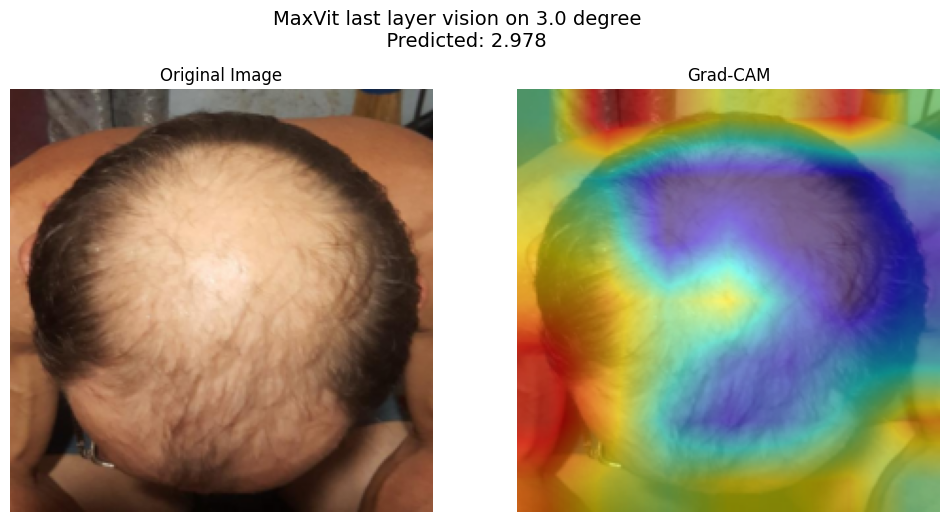

In [245]:
visualize_cam_on_image(37)

**Findings**  
Unlike the first image, the model seems to have more congruent activations:  
- The Center: The balding center is cool (blue/purple), indicating the model isn't "seeing" hair there.

- The Ring: The activation (yellow/green) forms a rough ring around the bald spot.

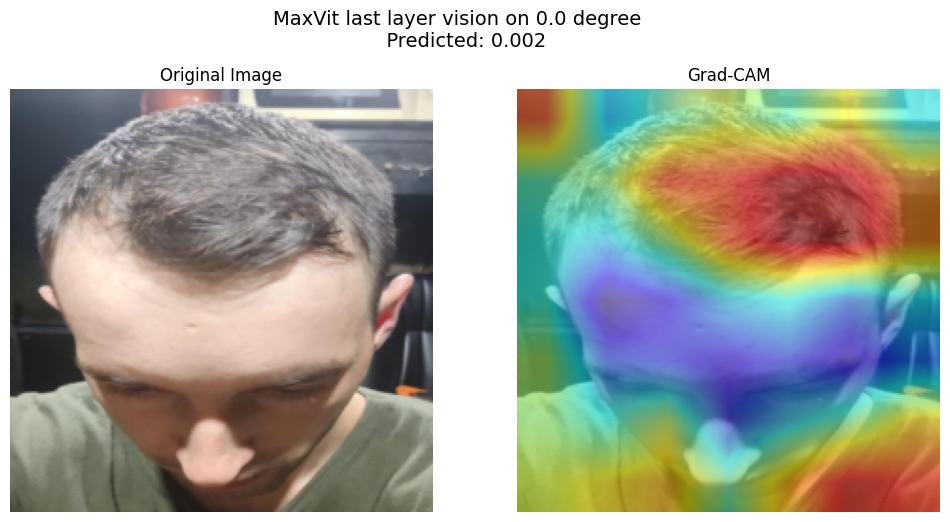

In [246]:
visualize_cam_on_image(7, images_tensor, labels_tensor, model, cam)

**Findings**  
Like the last image, the model is being activated by hair texture:
- Hot area: present almost entierly on top of the subject's head, correctly indentifying the texture.
- Cold area: Completly ignores the subject's face, including the left hair receding.


#### Wrongly classified samples

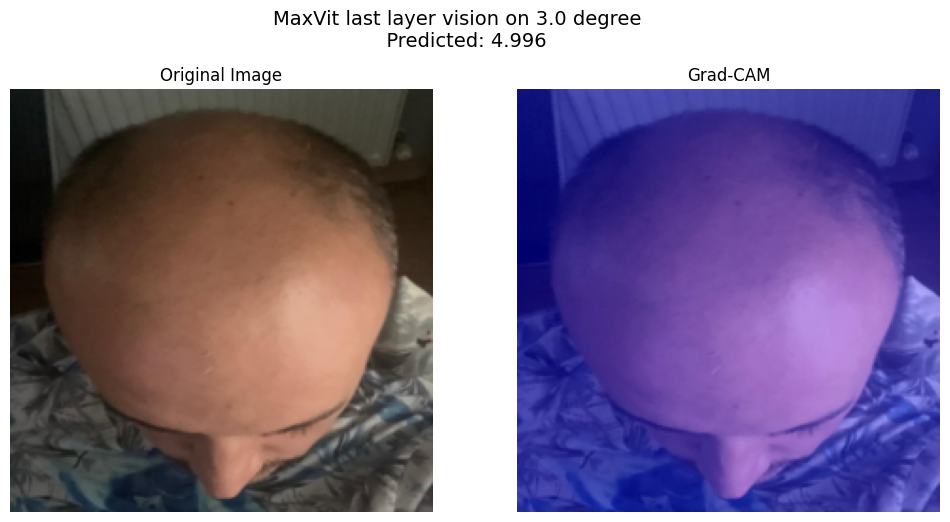

In [247]:
visualize_cam_on_image(0)

**Findings**  
Due to the poor illumination the models seems to ignore the low density dark hair of the subject, which blends with the background.  
Since the hairless zone is the most distinguishable it lead the model to give the highest score.

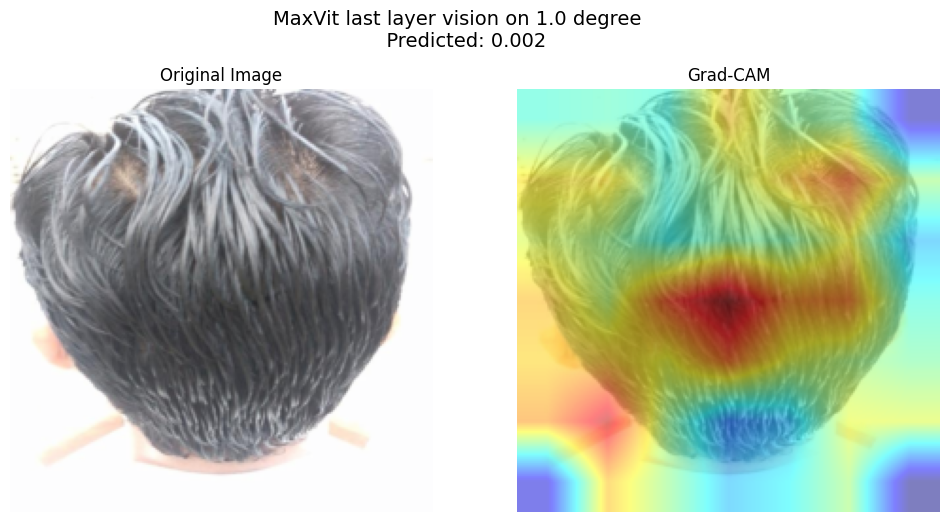

In [248]:
visualize_cam_on_image(4)

**Findings**  
In this a great example of how to not use the model:
1. The photo is extremely exposed, which in some cases could lead to worse results
2. The subject is actively covering the low density zone with the hair style, leading to a lower prediction

### Conclusion

The MaxVit model is robust but not perfect, still afected by the user's usage. The odd heatmap in Degree 6 is not a failure; it is a characteristic of how the neural network handles "negative classes" (classes defined by what is missing rather than what is present).

- Positive Evidence: It detects hair to predict low scores.

- Negative Evidence: It relies on the lack of detection to predict high scores.
